In [13]:
import sys
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy

In [14]:
sys.path.insert(0, '..')  # Add the parent dir to the system path
%reload_ext autoreload
%autoreload 2
%aimport helper

helper.info()

torch version: 2.3.0
device: cpu


In [15]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

40 40 10 10


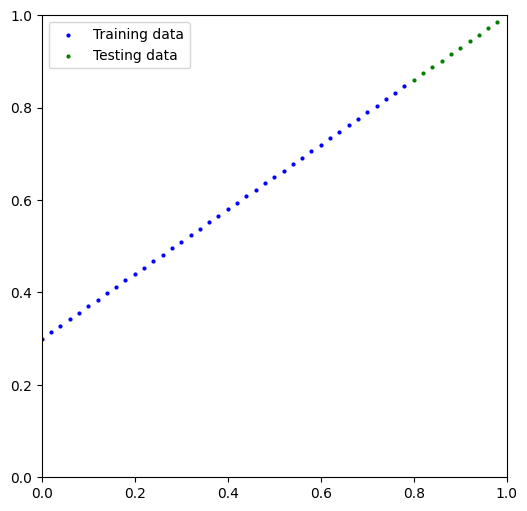

In [16]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))
helper.plot_predictions(X_train, y_train, X_test, y_test, None);

In [88]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [89]:
torch.manual_seed(2)
model_0 = LinearRegressionModel()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3923])), ('bias', tensor([-0.2236]))])

CPU times: user 26.6 ms, sys: 224 ms, total: 250 ms
Wall time: 17.7 ms


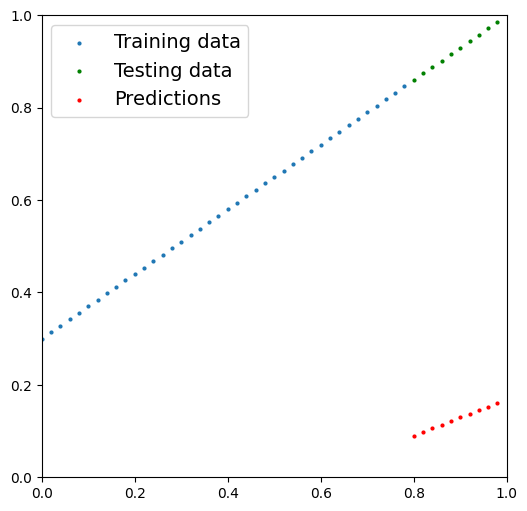

In [90]:
%%time
model_0.eval()
with torch.inference_mode(): 
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

In [91]:
torch.manual_seed(2)

model_0 = LinearRegressionModel()
loss_fn = nn.L1Loss() # MAE
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1101

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    model_0.train()
    y_pred = model_0(X_train)
    # print(y_pred)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # gradient descent (update the parameters)

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      test_pred = model_0(X_test) # forward pass
      test_loss = loss_fn(test_pred, y_test.type(torch.float))

      # Print out what's happening
      if epoch % 50 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch:2d} | MAE Train Loss: {loss:.3f} | MAE Test Loss: {test_loss:.3f} ")

Epoch:  0 | MAE Train Loss: 0.644 | MAE Test Loss: 0.796 
Epoch: 50 | MAE Train Loss: 0.586 | MAE Test Loss: 0.729 
Epoch: 100 | MAE Train Loss: 0.528 | MAE Test Loss: 0.661 
Epoch: 150 | MAE Train Loss: 0.471 | MAE Test Loss: 0.594 
Epoch: 200 | MAE Train Loss: 0.413 | MAE Test Loss: 0.527 
Epoch: 250 | MAE Train Loss: 0.356 | MAE Test Loss: 0.459 
Epoch: 300 | MAE Train Loss: 0.298 | MAE Test Loss: 0.392 
Epoch: 350 | MAE Train Loss: 0.240 | MAE Test Loss: 0.325 
Epoch: 400 | MAE Train Loss: 0.183 | MAE Test Loss: 0.257 
Epoch: 450 | MAE Train Loss: 0.125 | MAE Test Loss: 0.190 
Epoch: 500 | MAE Train Loss: 0.068 | MAE Test Loss: 0.123 
Epoch: 550 | MAE Train Loss: 0.023 | MAE Test Loss: 0.064 
Epoch: 600 | MAE Train Loss: 0.016 | MAE Test Loss: 0.041 
Epoch: 650 | MAE Train Loss: 0.014 | MAE Test Loss: 0.034 
Epoch: 700 | MAE Train Loss: 0.012 | MAE Test Loss: 0.029 
Epoch: 750 | MAE Train Loss: 0.011 | MAE Test Loss: 0.025 
Epoch: 800 | MAE Train Loss: 0.009 | MAE Test Loss: 0.021 

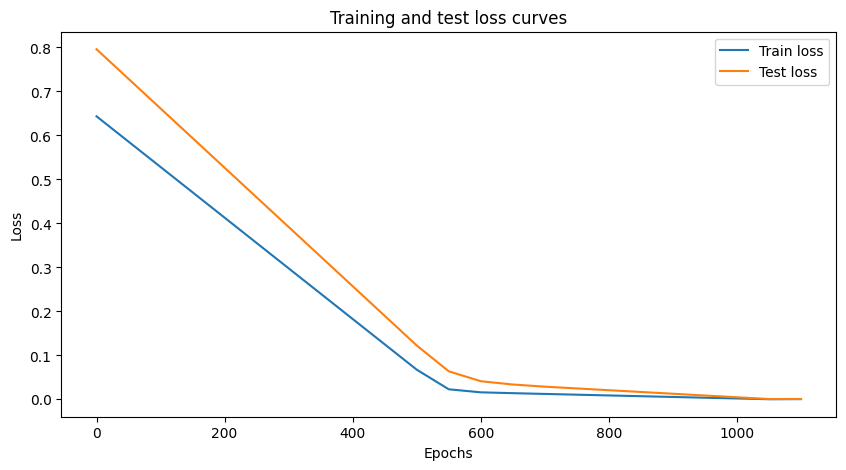

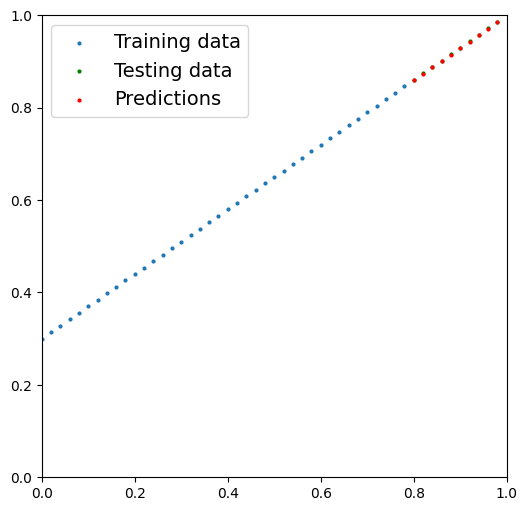

In [92]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

with torch.inference_mode(): 
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

In [93]:
from pathlib import Path

MODEL_PATH = Path(".")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "model_0_state.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) 

# Check the saved file path
!ls -hl {MODEL_SAVE_PATH}

-rw-r--r--  1 igorkost  staff   1.0K May 27 10:07 model_0_state.pth


In [94]:
loaded_model_0 = LinearRegressionModel() # random weights
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)) # this will update the new instance of our model with trained weights
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [98]:
torch.iinfo(model_0)

TypeError: iinfo(): argument 'type' (position 1) must be torch.dtype, not LinearRegressionModel